In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [43]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

# Exploratory Data Analysis


## Correlation Analysis


In [4]:
# Overview of the dataset
X.info()

# Display the first few rows
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [5]:
X.describe(include=['object', 'category'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,44923,45211,43354,45211,45211,45211,32191,45211,8252
unique,11,3,3,2,2,2,2,12,3
top,blue-collar,married,secondary,no,yes,no,cellular,may,failure
freq,9732,27214,23202,44396,25130,37967,29285,13766,4901


In [6]:
X.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


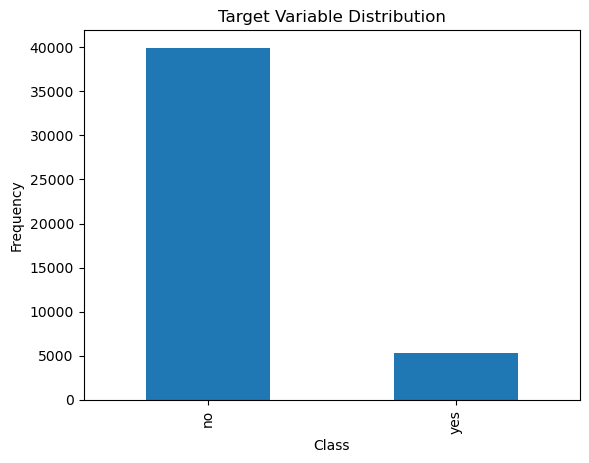

In [7]:
y['y'].value_counts().plot(kind='bar')
plt.title('Target Variable Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Calculate percentage distribution
class_distribution = y['y'].value_counts(normalize=True) * 100
print(class_distribution)

y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


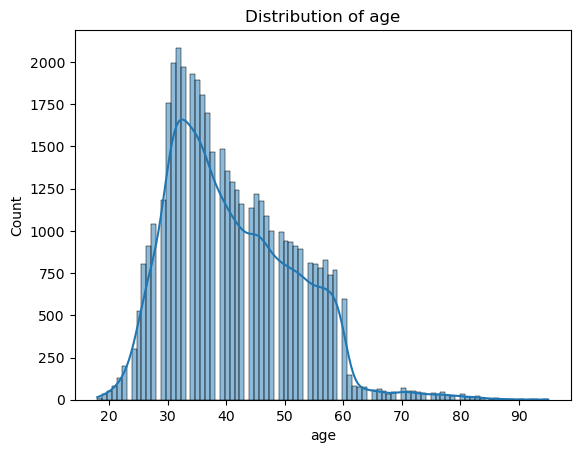

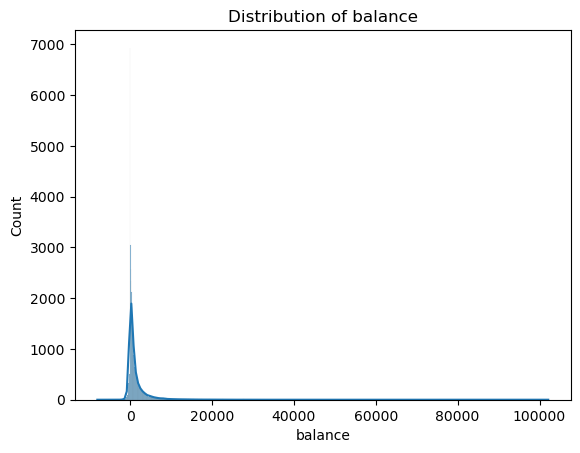

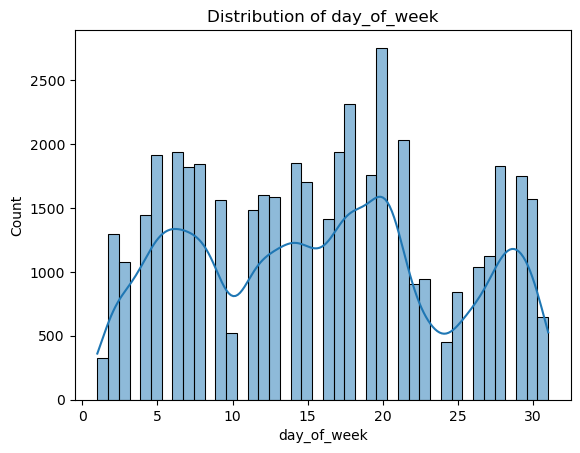

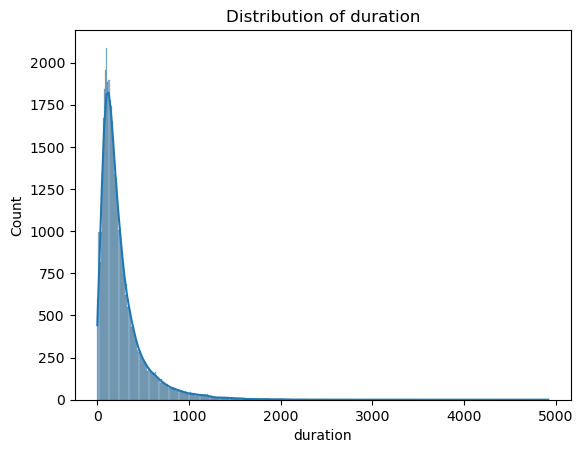

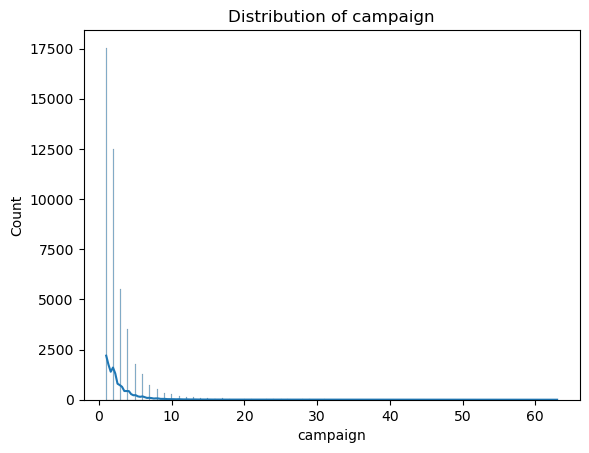

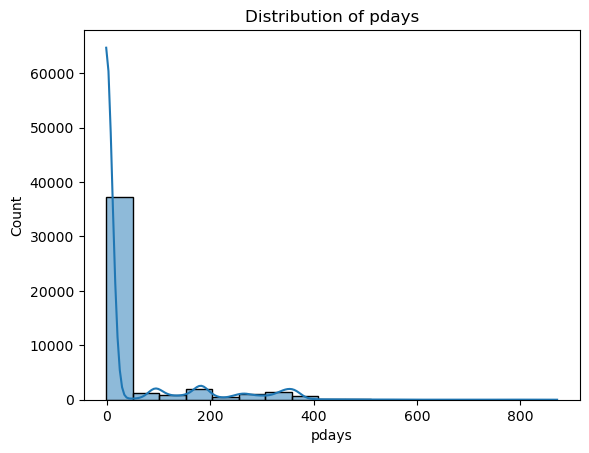

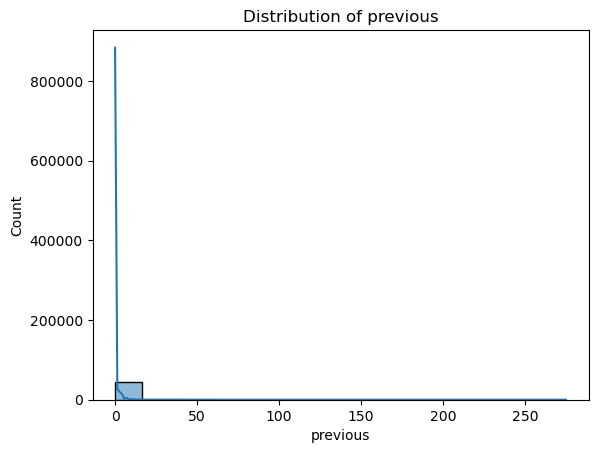

In [9]:
# Distribution plots for numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Data Cleaning


## Handle Missing Values


In [10]:
# X['job'].fillna(X['job'].mode, inplace = True)
# X['education'].fillna(X['education'].mode, inplace = True)
# X.isna().sum()

# Initialize LabelEncoder
le= LabelEncoder()

# Create a copy of the original 'education' column
X['education_original'] = X['education']
X['job_original'] = X['job']
X['marital_original'] = X['marital']
X['day_of_week_original'] = X['day_of_week']
X['month_original'] = X['month']
X['default_original'] = X['default']
X['housing_original'] = X['housing']
X['loan_original'] = X['loan']
y['y_original'] = y['y']

# Converting non-numeric features to numeric
X['marital'] = le.fit_transform(X['marital'].astype(str))
X['day_of_week'] = le.fit_transform(X['day_of_week'].astype(str))
X['month'] = le.fit_transform(X['month'].astype(str))
X['default'] = le.fit_transform(X['default'].astype(str))
X['housing'] = le.fit_transform(X['housing'].astype(str))
X['loan'] = le.fit_transform(X['loan'].astype(str))
y['y'] = le.fit_transform(y['y'].astype(str))

# Apply Label Encoding to the 'job' column (NaN values will remain NaN)
X['education'] = le.fit_transform(X['education'].astype(str))
X['job'] = le.fit_transform(X['job'].astype(str))

# Display the encoded values
print(X[['education', 'education_original']].head())
print(X[['job', 'job_original']].head())

   education education_original
0          3           tertiary
1          2          secondary
2          2          secondary
3          0                NaN
4          0                NaN
   job  job_original
0    4    management
1   10    technician
2    2  entrepreneur
3    1   blue-collar
4    5           NaN


/var/folders/5w/33hfrtd95yn9l9rh0g1b9h5r0000gn/T/ipykernel_85502/4133436850.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['y_original'] = y['y']
/var/folders/5w/33hfrtd95yn9l9rh0g1b9h5r0000gn/T/ipykernel_85502/4133436850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['y'] = le.fit_transform(y['y'].astype(str))


In [11]:
# Change NaN labels into a unique identifier
X['education'] = X['education'].replace(0,99)
X['job'] = X['job'].replace(5,99)

# Display the encoded values
print(X[['education', 'education_original']].head())
print(X[['job', 'job_original']].head())

   education education_original
0          3           tertiary
1          2          secondary
2          2          secondary
3         99                NaN
4         99                NaN
   job  job_original
0    4    management
1   10    technician
2    2  entrepreneur
3    1   blue-collar
4   99           NaN


In [12]:
# Select features that could be relevant to job for imputation
features_for_imputation = ['age', 'default', 'balance', 'housing', 'loan',
                           'day_of_week','month', 'duration', 'campaign', 'pdays',
                           'previous', 'marital', 'education', 'job']

# Dataframe with selected features
data_subset = X[features_for_imputation]
print(data_subset.head())

# Scale the data
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(data_subset), columns=data_subset.columns)

# Initialize KNNImputer (use n_neighbors=5 by default or any other number of neighbors)
imputer = KNNImputer(n_neighbors=5, missing_values=99)

# Perform KNN Imputation (fit and transform the data)
imputed_data = imputer.fit_transform(data_subset)

# Convert imputed data back into a DataFrame
data_imputed = pd.DataFrame(imputed_data, columns=features_for_imputation)

# Round the imputed job values to the nearest integer (as job is categorical)
data_imputed['education'] = np.round(data_imputed['education']).astype(int)
data_imputed['job'] = np.round(data_imputed['job']).astype(int)

# Display the imputed values
print(data_imputed.head())


   age  default  balance  housing  loan  day_of_week  month  duration  \
0   58        0     2143        1     0           26      8       261   
1   44        0       29        1     0           26      8       151   
2   33        0        2        1     1           26      8        76   
3   47        0     1506        1     0           26      8        92   
4   33        0        1        0     0           26      8       198   

   campaign  pdays  previous  marital  education  job  
0         1     -1         0        1          3    4  
1         1     -1         0        2          2   10  
2         1     -1         0        1          2    2  
3         1     -1         0        1         99    1  
4         1     -1         0        2         99   99  
    age  default  balance  housing  loan  day_of_week  month  duration  \
0  58.0      0.0   2143.0      1.0   0.0         26.0    8.0     261.0   
1  44.0      0.0     29.0      1.0   0.0         26.0    8.0     151.0   
2  

# Feature Engineering


In [13]:
print(y['y'].value_counts(normalize=True))

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


## Handle imbalanced target variable


In [14]:
# SMOTE (Synthetic Minority Oversampling Technique)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_imputed, y['y'])

print(f"Class distribution after resampling: {np.bincount(y_resampled)}")

Class distribution after resampling: [39922 39922]


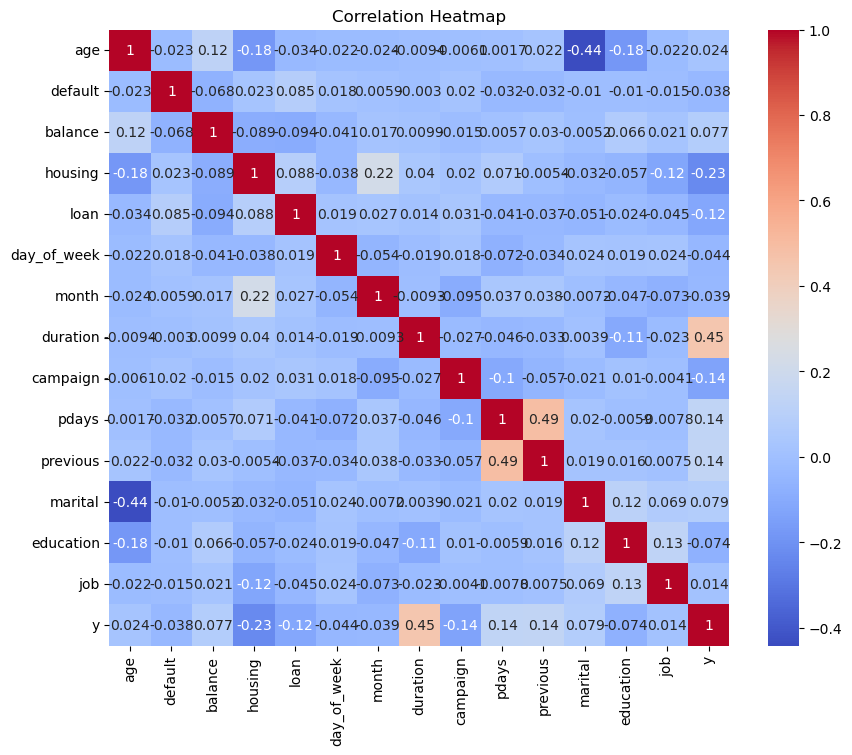

In [15]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = pd.concat([X_resampled, y_resampled], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Tree-Based Feature Importance


        Feature  Importance
7      duration    0.263897
3       housing    0.154717
6         month    0.098570
11      marital    0.097288
8      campaign    0.068343
2       balance    0.051099
0           age    0.048233
5   day_of_week    0.047017
10     previous    0.043547
4          loan    0.038933
9         pdays    0.038559
13          job    0.035171
12    education    0.013262
1       default    0.001363


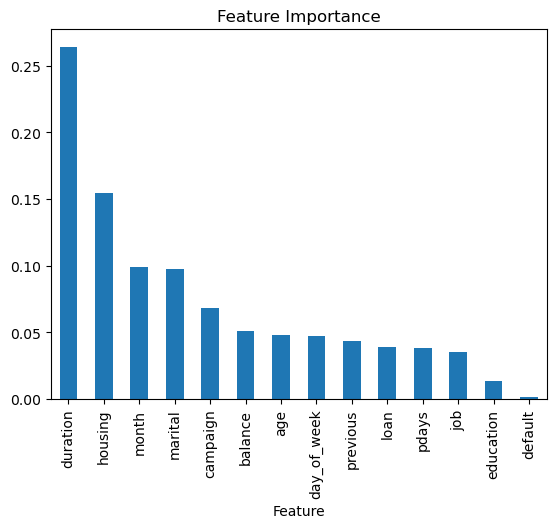

In [16]:
# Train a simple model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

# Get feature importance
feature_importances = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Visualize feature importance
feature_importances.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance')
plt.show()

In [17]:
# Drop irrelevant features
X_resampled = X_resampled.drop(['duration'],axis=1)

## Split the data into training and testing sets


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (63875, 13)
X_test shape: (15969, 13)
y_train shape: (63875,)
y_test shape: (15969,)


## Train and evaluate models

### Logistic Regression


In [19]:
# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42, class_weight='balanced')

# Train the model
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_log_reg, pos_label=1):.4f}")

Logistic Regression Performance:
Accuracy: 0.6252
Precision: 0.6485
Recall: 0.5623
F1 Score: 0.6024


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Classifier


In [20]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, pos_label=1):.4f}")

Random Forest Performance:
Accuracy: 0.9285
Precision: 0.9610
Recall: 0.8948
F1 Score: 0.9267


### XGBoost Classifier


In [34]:
# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model
print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb, pos_label=1):.4f}")


XGBoost Performance:
Accuracy: 0.9297
Precision: 0.9668
Recall: 0.8915
F1 Score: 0.9276


## Cross Validation


In [35]:
# Perform cross-validation on Random Forest
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"RandomForestClassifier Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC_AUC Score: {cv_scores.mean():.4f}")

# Perform cross-validation on XGBoost
cv_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc')
print(f"XGBoost Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC_AUC Score: {cv_scores.mean():.4f}")

RandomForestClassifier Cross-Validation ROC-AUC Scores: [0.96989223 0.97226937 0.97093669 0.97140228 0.97010059]
Mean ROC_AUC Score: 0.9709
XGBoost Cross-Validation ROC-AUC Scores: [0.96919816 0.97045957 0.96985319 0.97060417 0.96805154]
Mean ROC_AUC Score: 0.9696


In [37]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Shrinkage rate
    'max_depth': [3, 5, 7, 10],                 # Maximum tree depth
    'subsample': [0.6, 0.8, 1.0],               # Fraction of samples used for training
    'colsample_bytree': [0.6, 0.8, 1.0],        # Fraction of features for each tree
    'gamma': [0, 1, 5],                         # Minimum loss reduction for split
    'reg_alpha': [0, 0.1, 1],                   # L1 regularization
    'reg_lambda': [1, 2, 5],                    # L2 regularization
}

xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=param_grid,
    n_iter=50,            # Number of parameter settings sampled
    scoring='f1_macro',   # Evaluation metric
    cv=5,                 # 5-fold cross-validation
    random_state=42,
    verbose=1,
    n_jobs=-1             # Use all available cores
)

# Fit to training data
xgb_random_search.fit(X_train, y_train)

# Display best parameters
print(f"Best Parameters: {xgb_random_search.best_params_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      7908
           1       0.97      0.90      0.93      8061

    accuracy                           0.93     15969
   macro avg       0.94      0.93      0.93     15969
weighted avg       0.94      0.93      0.93     15969

ROC-AUC Score: 0.9678


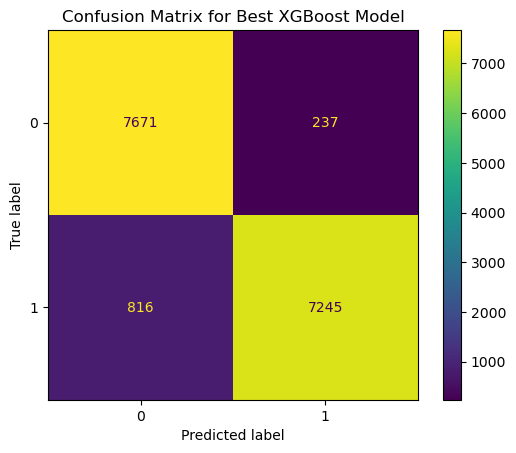

In [40]:
# Retrieve the best model
best_xgb = xgb_random_search.best_estimator_

# Predict on test data
y_pred_best_xgb = best_xgb.predict(X_test)
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_test, y_pred_best_xgb))

# Compute ROC-AUC
y_pred_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_best_xgb)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("Confusion Matrix for Best XGBoost Model")
plt.show()

In [42]:
# Save the model
joblib.dump(best_xgb, 'best_xgboost_model.pkl')
print("Best XGBoost Model Saved!")

Best XGBoost Model Saved!


<Figure size 1000x800 with 0 Axes>

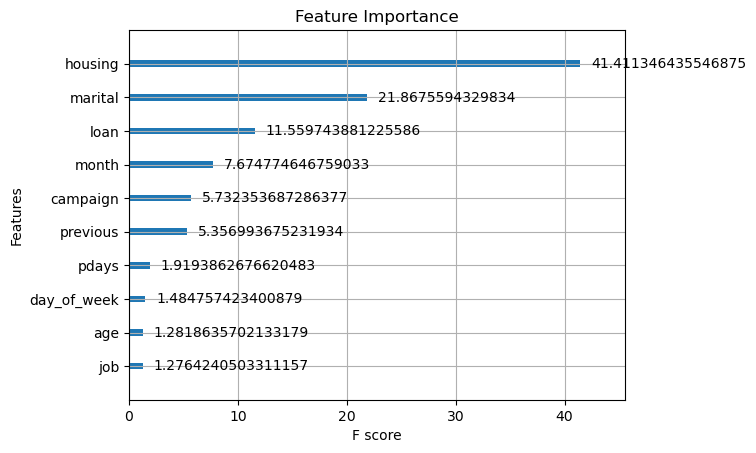

In [44]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, max_num_features=10, importance_type='gain')  # Top 10 features
plt.title('Feature Importance')
plt.show()